## Exploring NEON (National Ecological Observatory Network) AOP (Airborne Operations Platform) and NEON BioRepository Data Together

##### In this project, we will be looking at NEON AOP data for 2016 and 2017 in the GRSM (Great Smokey Mountains) Domain. Between the 2016 and 2017 collection of data, a large fire occurred in the domain leaving a prominent burn scar. We will be using the GEE (Google Earth Engine) API to explore the burn scar using the NBR (Normalize Burn Ratio) to set a threshold to identify burnt areas. We will then us the PyGBIF API (Python Global Biodiversity Information Facility) to pull records from the NEON BioRepository to see if and/or how Carabid beetle abundance in the domain were impacted by the fires.

## Part 2: Pulling + Visualizing Imagery and Occurence Records via APIs for Abundance

#### Step 1: Import and authenticate GEE and geemap with your username and project

In [ ]:
import ee
import geemap
from pygbif import occurrences as gbif_occ
from dotenv import load_dotenv
import geopandas as gpd
from shapely.geometry import Polygon
import pandas as pd
import os
import time
import zipfile
import io
import requests
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize(project="ee-krle4401")

##### Step 2: Define the Area of Interest and Inspect Available AOP Imagery

In this step, we define our **Area of Interest (AOI)** by specifying a central point within the GRSM domain. While you could use more complex geometries (e.g., shapefiles or bounding boxes), we use a simple **centroid** to capture all overlapping imagery from the domain.

We then load NEON's **Level 2 Hyperspectral Surface Reflectance Image Collection** from Google Earth Engine and extract the available image IDs. These IDs contain useful metadata, such as the year and NEON domain code (e.g., `GRSM`), which allows us to **filter images by site and year**.

We define a custom function `filter_aop_images()` that takes a list of years and NEON site codes, and returns only the image IDs that match these filters. This is helpful because NEON does not collect AOP imagery at every site every year. Our goal is to retrieve only the relevant GRSM images from **2016 and 2017**, the years surrounding the fire event.

This sets up the foundation for analyzing changes in burn severity using NBR, and later linking them to species data.


In [8]:
# Define an area of interest, for the imagery, I will simply be using a centroid because I want all
# the imagery from GRSM domain. You can using a bounding box, shapefiles, etc. if you want a more granular
# control of the geographic area
site_center = ee.Geometry.Point([-83.5, 35.7])

# Load Hyperspectral AOP Image Collection
sdr_col = ee.ImageCollection('projects/neon-prod-earthengine/assets/HSI_REFL/001')

# Retrieve all available image IDs to make a list if you want to see everything, but also to cross 
# reference years you may want
image_ids = sdr_col.aggregate_array("system:index").getInfo()
print("Available AOP Image IDs:", image_ids)

# Define a function that allows you to look through multiple years and domains of image collections
def filter_aop_images(years, domains):
    """
    Filters the AOP image collection based on a list of years and domains.
    
    Parameters:
        years (list): List of years (e.g., ["2016", "2017"]).
        domains (list): List of 4-letter site codes (e.g., ["GRSM", "HARV"]).
    
    Returns:
        Dictionary with (year, domain) as key and list of matching image IDs.
    """
    filtered_results = {}

    for year in years:
        for domain in domains:
            matching_ids = [img_id for img_id in image_ids if year in img_id and domain in img_id]
            if matching_ids:
                filtered_results[(year, domain)] = matching_ids

    return filtered_results

# Define years and domains that you want to look at (NOTE: this code can be used from multiple years
# and domains)
years_input = ["2016", "2017"]  # Add multiple years here
domains_input = ["GRSM"]  # Add multiple domains here

# Get image filtered by year and domain
filtered_images = filter_aop_images(years_input, domains_input)

# NEON does not fly every single domain every year so there may be years where imagery is unavailable
# I like to have a conditional statement so I can easily check if there are no images available, but 
# also print a list in case only some years are available
if not filtered_images:
    print(f"No AOP images found for the selected years and domains.")
else:
    print(f"Found AOP images: {filtered_images}")


Available AOP Image IDs: ['2013_CPER_1', '2014_HARV_2', '2014_JERC_1', '2015_MLBS_1', '2015_TALL_1', '2016_CLBJ_1', '2016_GRSM_2', '2016_HARV_3', '2016_JERC_2', '2016_SERC_1', '2016_TALL_2', '2017_CLBJ_2', '2017_CPER_3', '2017_GRSM_3', '2017_HARV_4', '2017_JERC_3', '2017_MLBS_2', '2017_OAES_2', '2017_SERC_3', '2017_SRER_1', '2017_TALL_3', '2018_GUAN_1', '2018_HARV_5', '2018_JERC_4', '2018_MCRA_1', '2018_MLBS_3', '2018_OAES_3', '2018_SRER_2', '2018_TALL_4', '2019_CLBJ_4', '2019_HARV_6', '2019_HEAL_3', '2019_JERC_5', '2019_JORN_3', '2019_NIWO_3', '2019_OAES_4', '2019_SERC_4', '2019_SOAP_4', '2019_SRER_3', '2019_TALL_5', '2020_CPER_5', '2020_CPER_7', '2020_NIWO_4', '2020_RMNP_3', '2020_YELL_3', '2021_ABBY_4', '2021_BONA_4', '2021_CLBJ_5', '2021_CPER_8', '2021_HEAL_4', '2021_JERC_6', '2021_JORN_4', '2021_MCRA_2', '2021_OAES_5', '2021_OSBS_6', '2021_SERC_5', '2021_SJER_5', '2021_SOAP_5', '2021_SRER_4', '2021_TALL_6']
Found AOP images: {('2016', 'GRSM'): ['2016_GRSM_2'], ('2017', 'GRSM'): ['

##### Step 3: In this step, we compute the **Normalized Burn Ratio (NBR)**, a common remote sensing index used to assess burn severity in vegetation. NBR is calculated as:

$$
\text{NBR} = \frac{\text{NIR} - \text{SWIR2}}{\text{NIR} + \text{SWIR2}}
$$

For NEON hyperspectral imagery, we use **Band 097** (Near-Infrared, \~865 nm) and **Band 220** (Shortwave Infrared 2, \~2190 nm), which closely approximate the NBR formula.

We define a function `addNBRBands()` that adds an `NBR` band to each image and tag it with a `"Sensor": "AOP"` property for clarity.

Then, for each filtered image (based on year and domain), we:

1. Retrieve the image from the collection by its `system:index`.
2. Compute the NBR band using our custom function.
3. Add the NBR layer to a **geemap** interactive map using a color palette that reflects burn severity:

   * White: low or no burn
   * Yellow to Red: moderate burn
   * Black: severe burn

Finally, we export the map to an HTML file for easy sharing or offline viewing.

This visualization helps us identify where the fire burn scar is most prominent and sets the stage for spatial comparison with biodiversity records.

In [9]:
# NBR Visualization Parameters
nbr_vis_params = {
    'min': -1, 'max': 1,
    'palette': ['white', 'yellow', 'red', 'black']  # typical burn severity color ramp
}

# Function to Compute NBR
def addNBRBands(image):
    nbr = image.normalizedDifference(['B097', 'B220']).rename('NBR')
    return image.addBands(nbr).set({'Sensor': 'AOP'})

# Create a geemap Map instance for NBR visualization
NBR_Map = geemap.Map()
NBR_Map.centerObject(site_center, 11)

# Loop through filtered images and compute NBR
for (year, domain), image_ids in filtered_images.items():
    for image_id in image_ids:
        # Retrieve the image by its system:index
        aop_image = sdr_col.filter(ee.Filter.eq("system:index", image_id)).first()

        # Compute NBR
        if aop_image:
            aop_nbr = addNBRBands(aop_image).select('NBR')
            print(f"NBR computed for AOP image: {image_id}")

            # Add layer with proper naming
            NBR_Map.addLayer(aop_nbr, nbr_vis_params, f'AOP NBR ({image_id})')

# Save the final interactive HTML map for NBR
html_nbr_filename = f"AOP_NBR_{'_'.join(years_input)}_{'_'.join(domains_input)}.html"
NBR_Map.to_html(filename=html_nbr_filename)

print(f"NBR visualization saved: {html_nbr_filename}")

NBR computed for AOP image: 2016_GRSM_2
NBR computed for AOP image: 2017_GRSM_3
NBR visualization saved: AOP_NBR_2016_2017_GRSM.html


#### Step 4: Submit a GBIF Download Request for Multiple Datasets

In this step, we use the **GBIF Download API** to submit a query for all occurrence records that match our defined filters. Unlike quick search functions, this method allows you to access **bulk datasets** and is especially useful for:

* **Combining multiple datasets**, each with potentially different sampling designs,
* Retrieving **abundance-relevant data** (i.e., repeated occurrences per species or trap),
* Downloading standardized Darwin Core Archive (DWCA) files that include metadata, occurrences, and optional extensions.

Our predicate includes the following filters:

* Records from any of the specified **dataset keys**, which represent curated collections relevant to the GRSM domain.
* Occurrences **within our bounding box** around Great Smoky Mountains National Park.
* Only records that **include geographic coordinates**.
* Temporal filter for **2016 and 2017** to match our fire comparison timeframe.

The result is submitted as a background job to GBIF's system. Once completed, we’ll be able to download the data in `.zip` format for local use.

> ⚠️ You must authenticate using your GBIF account credentials to use this method.

This submission lays the groundwork for downloading and parsing biodiversity records in a standardized, analysis-ready format.

In [15]:
from pygbif import occurrences as gbif_occ
from dotenv import load_dotenv
import geopandas as gpd
from shapely.geometry import Polygon
import pandas as pd
import os
import time
import zipfile
import io
import requests

# ====================================
# 1. Load GBIF credentials from .env
# ====================================
load_dotenv()
user = os.environ["GBIF_USER"]
pwd = os.environ["GBIF_PWD"]
email = os.environ["GBIF_EMAIL"]

# ====================================
# 2. Define bounding box around GSMNP
# ====================================
latitude, longitude = 35.6118, -83.4895
bbox_size_deg = 0.09
bounding_box_coords = [
    (longitude - bbox_size_deg, latitude - bbox_size_deg),
    (longitude + bbox_size_deg, latitude - bbox_size_deg),
    (longitude + bbox_size_deg, latitude + bbox_size_deg),
    (longitude - bbox_size_deg, latitude + bbox_size_deg),
    (longitude - bbox_size_deg, latitude - bbox_size_deg)
]
bounding_polygon = Polygon(bounding_box_coords)
polygon_wkt = bounding_polygon.wkt

# ====================================
# 3. Build GBIF predicate with multiple datasets
# ====================================
dataset_keys = [
    "8cb7c449-ba11-4464-865e-8029b8d772e8",  
    "69e5ceb4-30a6-4074-8f9d-d6a0457cb789",  
    "044d870e-5718-410a-9450-9c2ceac8e1d9",  
    "2564e9e2-0248-4a3b-8344-24fc0956ed73"   
]

predicate = {
    "type": "and",
    "predicates": [
        {"type": "in", "key": "DATASET_KEY", "values": dataset_keys},
        {"type": "within", "geometry": polygon_wkt},
        {"type": "equals", "key": "HAS_COORDINATE", "value": "true"},
        {"type": "in", "key": "YEAR", "values": ["2016", "2017"]}
    ]
}

# ====================================
# 4. Submit the GBIF download request
# ====================================
download_key, _ = gbif_occ.download(
    predicate,
    user=user,
    pwd=pwd,
    email=email,
    format="DWCA"
)
print(f"Download key submitted: {download_key}")

# ====================================
# 5. Wait for download to complete
# ====================================
status = gbif_occ.download_meta(download_key)["status"]
while status != "SUCCEEDED":
    print(f"Status: {status}... waiting 10s")
    time.sleep(10)
    status = gbif_occ.download_meta(download_key)["status"]

print("Download succeeded!")
print(f"GBIF DOI: https://doi.org/10.15468/dl.{download_key}")
print(f"Download URL: https://api.gbif.org/v1/occurrence/download/request/{download_key}.zip")

# ====================================
# 6. Download and unzip the data
# ====================================
dwca_url = f"https://api.gbif.org/v1/occurrence/download/request/{download_key}.zip"
r = requests.get(dwca_url)
with zipfile.ZipFile(io.BytesIO(r.content)) as z:
    z.extractall(f"./{download_key}")



INFO:Your download key is 0088885-250525065834625


Download key submitted: 0088885-250525065834625
Status: PREPARING... waiting 10s
Status: PREPARING... waiting 10s
Status: PREPARING... waiting 10s
Status: PREPARING... waiting 10s
Status: PREPARING... waiting 10s
Status: PREPARING... waiting 10s
Status: RUNNING... waiting 10s
Status: RUNNING... waiting 10s
Status: RUNNING... waiting 10s
Status: RUNNING... waiting 10s
Status: RUNNING... waiting 10s
Status: RUNNING... waiting 10s
Status: RUNNING... waiting 10s
Status: RUNNING... waiting 10s
Status: RUNNING... waiting 10s
Status: RUNNING... waiting 10s
Download succeeded!
GBIF DOI: https://doi.org/10.15468/dl.0088885-250525065834625
Download URL: https://api.gbif.org/v1/occurrence/download/request/0088885-250525065834625.zip


In [16]:
# ====================================
# 7. Load and process the DWCA occurrence data
# ====================================
occurrence_path = f"./{download_key}/occurrence.txt"
df = pd.read_csv(occurrence_path, sep='\t', low_memory=False)

# Filter to only rows with eventID starting with 'grsm.'
if "eventID" in df.columns:
    df = df[df["eventID"].notna()]
    df = df[df["eventID"].str.lower().str.startswith("grsm.")]
    print(f"Filtered to {len(df)} records with GRSM-prefixed eventID.")
else:
    print("No 'eventID' column found in the downloaded DWCA.")

# Drop rows with missing coordinates
df = df.dropna(subset=["decimalLatitude", "decimalLongitude"])

# Retain only the relevant columns
desired_cols = ["species", "decimalLatitude", "decimalLongitude", "year", "eventID", "datasetKey"]
existing_cols = [col for col in desired_cols if col in df.columns]
df = df[existing_cols]

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["decimalLongitude"], df["decimalLatitude"]),
    crs="EPSG:4326"
)

# ====================================
# 8. Export to GeoJSON and CSV
# ====================================
gdf.to_file("gbif_selected_datasets_2016_2017.geojson", driver="GeoJSON")
gdf.drop(columns="geometry").to_csv("gbif_selected_datasets_2016_2017.csv", index=False)

print("Export complete!")


INFO:Created 514 records


Filtered to 514 records with GRSM-prefixed eventID.
Export complete!


##### Step 5: Visualize AOP Burn Scar Imagery and GBIF Carabid Beetle Records Together

Now that we have both:

* **NBR layers** derived from NEON hyperspectral imagery (2016 and 2017), and
* **Carabidae beetle occurrence records** from GBIF filtered for the same years,

we can overlay them on an interactive map to explore spatial relationships between fire impact and species presence.

Here’s what this step does:

1. **Load the GBIF records** from the previously exported GeoJSON file.
2. **Split the data by year**, so we can view 2016 and 2017 occurrences separately.
3. **Add the beetle occurrence points to the existing `NBR_Map`**, using distinct layers for each year. This enables easy visual comparison of beetle distribution before and after the fire.
4. **(Optional)** Save the combined interactive map as an HTML file, allowing offline exploration or embedding in web resources.

This combined view provides a powerful tool to assess change and potential disturbance impacts on species distributions across time.


In [12]:
# Load GBIF records from the GeoJSON file
gbif_geojson = "/Users/kitlewers/GBIF_Remote_Sensing_Webinar_Notebooks/NEON_GRSM_Burn_Scars/code/DOWNLOADED_abundance_gbif_carabids_gsmnp_2016_2017.geojson"
carabid_gdf = gpd.read_file(gbif_geojson)

# Separate the GBIF records by year
carabid_2016 = carabid_gdf[carabid_gdf["year"] == 2016]
carabid_2017 = carabid_gdf[carabid_gdf["year"] == 2017]

# Add the GBIF points to the map as separate layers
NBR_Map.add_gdf(carabid_2016, layer_name="GBIF NEON Carabidae Trap Records 2016")
NBR_Map.add_gdf(carabid_2017, layer_name="GBIF NEON Carabidae Trap Records 2017")

# (Optional) Save the interactive NBR_map to an HTML file
output_html = "Combined_NBR_GBIF_NBR_Map.html"
NBR_Map.to_html(filename=output_html)
print(f"Combined map saved as: {output_html}")

Combined map saved as: Combined_NBR_GBIF_NBR_Map.html


##### Step 6: Analyze Burn Severity and Extract Burn Scar Polygons

In this step, we dig deeper into the burn analysis by quantifying and mapping **burn severity** between 2016 and 2017 using the **difference in Normalized Burn Ratio (dNBR)**. This is a widely used metric for post-fire assessment.

Here's a breakdown of what we're doing:

1. **Select representative images**: We pick one AOP image from **before** (2016) and **after** (2017) the fire event in GRSM.
2. **Compute NBR for each image**: Using the `addNBRBands()` function, we generate an `NBR` band for each image based on near-infrared and shortwave-infrared bands.
3. **Calculate dNBR**: We subtract the 2017 (post-fire) NBR from the 2016 (pre-fire) NBR to highlight change. Higher values represent greater burn severity.
4. **Classify burned areas**: We apply a **threshold of 0.27** to the dNBR layer to isolate pixels indicative of **moderate to high burn severity**. This threshold is adjustable depending on calibration needs.
5. **Vectorize the burn scar**: We convert the binary burn mask into **polygon features** using `reduceToVectors()` within a 5 km buffered region around the study site. These vectors can be exported and used for further spatial analysis.
6. **Visualize everything**: We create an interactive map with:

   * dNBR heatmap
   * Binary burned/unburned mask
   * Vectorized burn scar polygons
7. **(Optional)**: We initiate an **Earth Engine export task** to download the burn scar polygons as a shapefile.

This step enables us to move beyond raw NBR values and extract **meaningful spatial features** representing fire impacts—setting the stage for overlap with biodiversity data.


In [13]:


# --- STEP 1: Select pre-fire and post-fire images ---
# Assuming filtered_images is a dictionary with keys like ('2016', 'GRSM') and ('2017', 'GRSM')
# Here we simply choose the first image ID for each year.
pre_fire_img_id = filtered_images.get(('2016', 'GRSM'))[0]
post_fire_img_id = filtered_images.get(('2017', 'GRSM'))[0]

# Retrieve the images from the collection
pre_fire_image = sdr_col.filter(ee.Filter.eq("system:index", pre_fire_img_id)).first()
post_fire_image = sdr_col.filter(ee.Filter.eq("system:index", post_fire_img_id)).first()

# --- STEP 2: Compute NBR for each image using your function ---
pre_fire_nbr = addNBRBands(pre_fire_image).select('NBR')
post_fire_nbr = addNBRBands(post_fire_image).select('NBR')

# --- STEP 3: Calculate dNBR (difference NBR) ---
dnbr = pre_fire_nbr.subtract(post_fire_nbr).rename('dNBR')

# --- STEP 4: Apply a threshold to classify burned areas ---
# Example: mark pixels as burned if dNBR > 0.27 (indicative of moderate to high burn severity)
burn_threshold = 0.27  # This value may be adjusted based on local calibration or sensor characteristics. I chose .27 due to other projects I'm working on.
burned_area_mask = dnbr.gt(burn_threshold)

# Optional: visualize burned vs unburned areas using a simple palette.
dnbr_viz_params = {
    'min': 0,
    'max': 1,
    'palette': ['white', 'orange', 'red']
}

# --- STEP 5: Vectorize the Burn Scar Mask ---
# Define a region of interest (ROI) for vectorization.
# You might base this on an extent around your site_center; here we buffer the center by 5000m or half a km.
# Again, feel free to change this based on your needs
roi = site_center.buffer(5000)

# Convert the burned area mask into vectors (polygons)
burn_vectors = burned_area_mask.selfMask().reduceToVectors(
    geometry=roi,
    crs=post_fire_image.projection(), 
    scale=10,  # Adjust scale (pixel size) as appropriate for the data.
    geometryType='polygon',
    labelProperty='burned',
    reducer=ee.Reducer.countEvery()
)

# --- STEP 6: Visualize the dNBR, burned area, and vectorized burn scar on the map ---
# Create a geemap Map instance (if not already created)
NBR_Map = geemap.Map()
NBR_Map.centerObject(site_center, 11)

# Add dNBR layer
NBR_Map.addLayer(dnbr, dnbr_viz_params, 'dNBR (Pre-fire minus Post-fire)')

# Add burned area mask layer
NBR_Map.addLayer(burned_area_mask.selfMask(), {'palette': 'red'}, 'Burned Area Mask')

# Add burn scar vectors layer
NBR_Map.addLayer(burn_vectors, {}, 'Burn Scar Polygons')

# Optionally, save the interactive map
output_html = "Burn_Scar_Map.html"
NBR_Map.to_html(filename=output_html)
print(f"Burn scar map saved as: {output_html}")

# --- Optional: Export the burn scar vectors as a shapefile ---
# If you wish to export the vector data from Earth Engine, use Export.table.toDrive.
export_task = ee.batch.Export.table.toDrive(
    collection=burn_vectors,
    description='BurnScar_Shapefile_Export',
    folder='EarthEngineExports',
    fileFormat='SHP'
)
export_task.start()
print("Export of burn scar shapefile initiated.")


Burn scar map saved as: Burn_Scar_Map.html
Export of burn scar shapefile initiated.


#### Step 7: Visualize Species Abundance in 2016 vs. 2017

Now that we’ve downloaded and processed occurrence records from multiple GBIF datasets, we shift our focus from **presence/absence** to **abundance** — specifically, the **number of records per species per year**. While GBIF does not always report individual counts, repeated occurrences at a site or across a region can be used as a **proxy for relative abundance**.

Here’s what this step does:

1. **Load the combined GeoJSON file** that contains GBIF occurrence records from the selected datasets for 2016 and 2017.
2. **Group the data by `species` and `year`**, and count the number of rows (i.e., records) for each combination. This gives us a measure of how frequently each species was observed in each year.
3. **Reshape the data into a pivot table**:

   * Rows = unique species
   * Columns = years (2016, 2017)
   * Values = number of occurrences (abundance)
4. **Visualize the results** as a **grouped bar chart**:

   * Each bar represents a species.
   * Bar heights compare the number of records in 2016 and 2017.
   * This allows for rapid identification of trends such as:

     * Species that appear or disappear between years
     * Species with reduced or increased records post-fire


This step provides a more nuanced picture of biodiversity change over time and can help you identify potential fire-sensitive or fire-resilient species based on how their recorded abundance changes.


year                       2016  2017
species                              
Amphasia interstitialis     0.0   1.0
Anillinus langdoni          0.0   1.0
Aulacopodus brouni          1.0   0.0
Carabus goryi              44.0  81.0
Cyclotrachelus freitagi    17.0   5.0
Cyclotrachelus sigillatus  33.0   5.0
Cylindera unipunctata       2.0   1.0
Dicaelus dilatatus         22.0  40.0
Dicaelus teter             28.0  26.0
Galerita bicolor           12.0   0.0
Gastrellarius blanchardi    1.0   0.0
Gastrellarius unicarum      0.0   1.0
Notiophilus aeneus          0.0   1.0
Pasimachus punctulatus     13.0  22.0
Pterostichus acutipes      32.0  37.0
Pterostichus coracinus      1.0   0.0
Pterostichus moestus       14.0   0.0
Pterostichus stygicus       1.0   0.0
Pterostichus tristis       15.0   4.0
Scaphinotus andrewsii       5.0   0.0
Scaphinotus guyotii         3.0   1.0
Scaphinotus hubbardi        0.0   1.0
Sphaeroderus bicarinatus   13.0   0.0
Sphaeroderus canadensis     9.0   0.0
Sphaeroderus

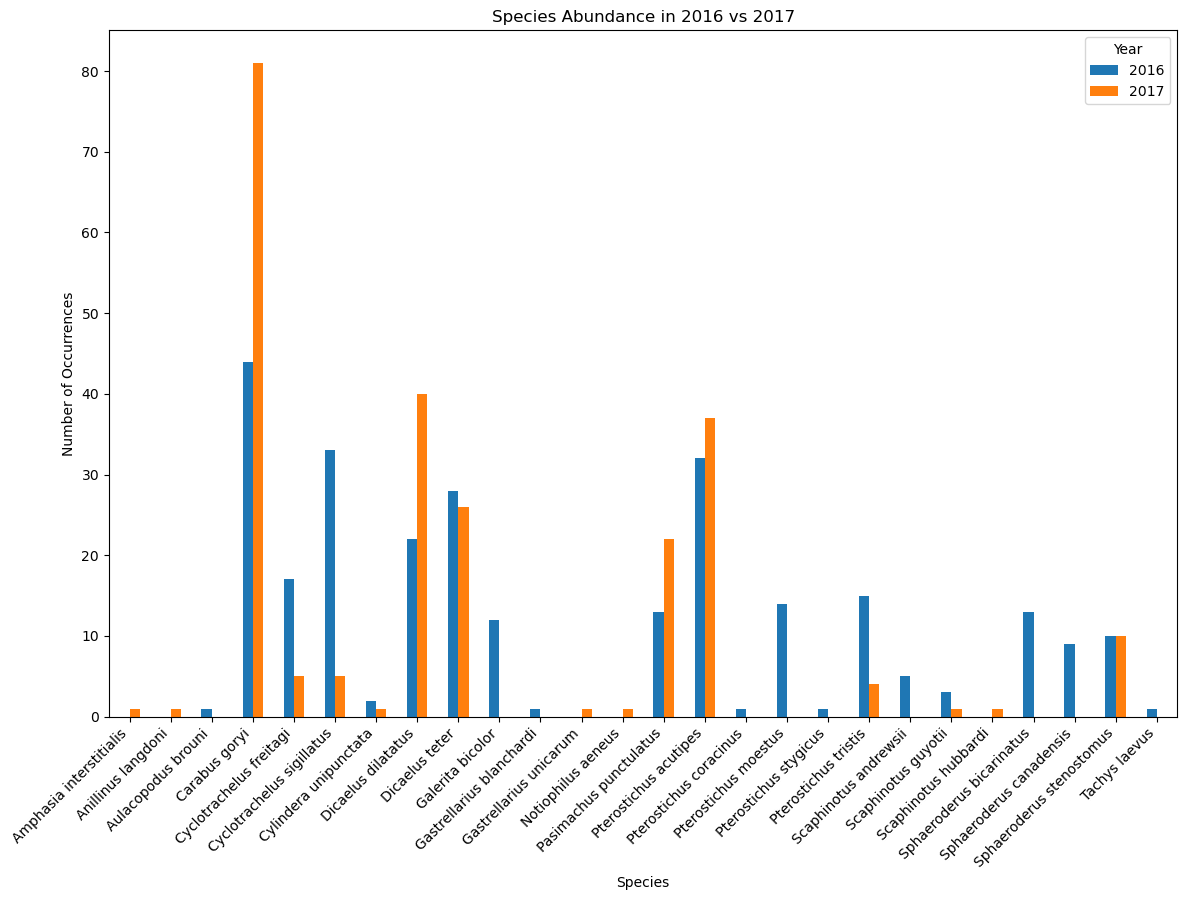

In [17]:
import geopandas as gpd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the GBIF GeoJSON
gbif_geojson = "/Users/kitlewers/GBIF_Remote_Sensing_Webinar_Notebooks/NEON_GRSM_Burn_Scars/code/gbif_selected_datasets_2016_2017.geojson"
gdf = gpd.read_file(gbif_geojson)

# Group by species and year, and count occurrences (i.e., abundance)
abundance_df = (
    gdf.groupby(['species', 'year'])
    .size()
    .reset_index(name='abundance')
)

# Pivot the data: rows = species, columns = year, values = abundance
abundance_pivot = abundance_df.pivot(index='species', columns='year', values='abundance').fillna(0)

# Sort species alphabetically (optional)
abundance_pivot = abundance_pivot.sort_index()

# Print table
print(abundance_pivot)

# Plot as a grouped bar chart
abundance_pivot.plot(kind='bar', figsize=(12, max(4, len(abundance_pivot) * 0.35)))
plt.title("Species Abundance in 2016 vs 2017")
plt.xlabel("Species")
plt.ylabel("Number of Occurrences")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(title='Year')
plt.show()


##### Step 8: Visualize Unique Trap Locations/Plots and Compare with Burn Severity

To better assess how the burn scar intersects with **insect trapping locations**, we first identify and extract the **unique geographic points** from the GBIF dataset.

Here's what this step does:

1. **Load the GeoJSON file** containing GBIF Carabidae records.
2. **Extract unique coordinate pairs** by deduplicating based solely on location (latitude & longitude), regardless of species or year.
3. **Construct a simplified GeoJSON** with only these unique points. Each point is represented as a minimal `Feature` with `Point` geometry and no additional attributes.
4. **Convert the data into an Earth Engine `FeatureCollection`**, allowing us to work with it spatially in GEE.
5. **Visualize the trap locations** on an interactive map using `geemap`, making it easy to verify whether the same plots were used across years.

This sets the stage for our next analysis: **overlaying burn severity data (e.g., NBR or dNBR values) onto these trap locations**, allowing us to compare how fire exposure may relate to changes in beetle presence and diversity.



In [19]:
import json

# Specify the local path to your GeoJSON file.
geojson_path = '/Users/kitlewers/GBIF_Remote_Sensing_Webinar_Notebooks/NEON_GRSM_Burn_Scars/code/gbif_selected_datasets_2016_2017.geojson'

# Open and load the GeoJSON as a Python dictionary.
with open(geojson_path, 'r') as f:
    geojson_data = json.load(f)

# Extract unique coordinate pairs from the features.
# We assume each feature is a Point geometry.
unique_coords = {}
for feature in geojson_data['features']:
    # Get geometry details.
    geom = feature.get('geometry', {})
    if geom.get('type') == 'Point':
        # Coordinates are typically stored as [longitude, latitude].
        coord = tuple(geom.get('coordinates'))
        # Use the coordinates as a key to deduplicate.
        if coord not in unique_coords:
            unique_coords[coord] = coord

# Create a new GeoJSON with only the unique points.
unique_features = []
for coord in unique_coords.keys():
    new_feature = {
        "type": "Feature",
        "geometry": {
            "type": "Point",
            "coordinates": list(coord)
        },
        "properties": {}  # Only lat/long are kept.
    }
    unique_features.append(new_feature)

unique_geojson = {
    "type": "FeatureCollection",
    "features": unique_features
}

print("Number of unique points:", len(unique_features))

# Create an Earth Engine FeatureCollection from the unique GeoJSON.
traps = ee.FeatureCollection(unique_geojson)

# (Optional) Visualize the unique trap points using geemap.
Map = geemap.Map(center=[35.7, -83.5], zoom=11)
Map.addLayer(traps, {}, 'Unique Points')


Number of unique points: 4


##### Step 9: Quantify Burn Severity Around Trap Locations

Now that we’ve generated a burn mask and identified unique insect trap locations, we can **quantify how much each trap plot was affected by the fire**.

Here’s what this step does:

1. **Buffer each trap point by 300 meters**, creating a circular area of interest around each trap to account for nearby fire effects.
2. **Use the `burn_mask` layer** (a binary raster of burned areas) to compute the **mean burn value within each buffer**:

   * Since burned pixels = 1 and unburned = 0, the **mean value within the buffer** corresponds to the **fraction of burned pixels**.
   * Multiplying this by 100 gives the **percent of the buffer that burned**.
3. **Attach the burn percentage to each trap point** using Earth Engine’s `map()` function and return the results as a new FeatureCollection.
4. **Visualize** the burn percentages on the interactive map to spot patterns across the landscape.
5. **Convert the Earth Engine data into a GeoPandas GeoDataFrame** for export and further offline analysis.
6. **Export the results**:

   * As a CSV file with geometry stored as WKT (well-known text) for tabular use.
   * As a GeoJSON file for use in GIS software or web-based mapping tools.

This step allows us to correlate local fire intensity with **species presence, absence, or richness** from earlier steps, offering a powerful lens for ecological disturbance analysis.



In [20]:
burn_mask = burned_area_mask.unmask(0).toFloat().rename('burn_mask')

traps_buffered = traps.map(lambda feature: feature.buffer(300))

# Step 4: Define a function to compute the percentage of burned pixels within each buffer.
def calculate_burn_percentage(feature):
    stats = burn_mask.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=feature.geometry(),
        scale=10,          # Adjust scale to match your sensor's resolution (e.g., 10 m)
        maxPixels=1e6
    )
    # The mean value corresponds to the fraction of burned pixels (0–1).
    burn_fraction = ee.Number(stats.get('burn_mask'))
    burn_percentage = burn_fraction.multiply(100)
    return feature.set({'burn_pct': burn_percentage})

# Apply the function to each buffered trap.
traps_with_burn = traps_buffered.map(calculate_burn_percentage)

# Optionally, print a sample of the computed burn percentages.
print('Burn percentages for trap buffers:', traps_with_burn.limit(10).getInfo())

# (Optional) Visualize the trap areas with burn percentage values on your existing map.
NBR_Map.addLayer(traps_with_burn, {}, 'Trap Areas with Burn %')


# Convert the Earth Engine FeatureCollection (with burn percentages) to a GeoDataFrame
gdf_traps = geemap.ee_to_gdf(traps_with_burn)
print("Converted GeoDataFrame:")
print(gdf_traps.head())

# Option 1: Export as CSV using pandas.
# For CSV export, the geometry column may be better exported as WKT.
gdf_traps_csv = gdf_traps.copy()
gdf_traps_csv['geometry'] = gdf_traps_csv['geometry'].apply(lambda geom: geom.wkt if geom is not None else None)
csv_filename = "Trap_Burn_Percentage_Export.csv"
gdf_traps_csv.to_csv(csv_filename, index=False)
print(f"Data exported as CSV: {csv_filename}")

# Option 2: Export as GeoJSON using GeoPandas.
# Here, we'll export the GeoDataFrame directly as a GeoJSON file.
geojson_filename = "Trap_Burn_Percentage_Export.geojson"
# (Make sure the geometry column contains proper shapely geometries; if you already converted to WKT above, use the original gdf_traps.)
gdf_traps.to_file(geojson_filename, driver="GeoJSON")
print(f"Data exported as GeoJSON: {geojson_filename}")


Burn percentages for trap buffers: {'type': 'FeatureCollection', 'columns': {'burn_pct': 'Number', 'system:index': 'String'}, 'features': [{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[-83.524234, 35.66718965978545], [-83.52516215579463, 35.66708220976496], [-83.52601642338209, 35.666768413553044], [-83.52672879824308, 35.66627325155342], [-83.52724257421, 35.665636141589395], [-83.5275168576299, 35.66490780033122], [-83.52752982158954, 35.66414620540121], [-83.52728044145039, 35.663411979837626], [-83.52678857413409, 35.66276356647543], [-83.52609337555741, 35.66225257637097], [-83.52525018279847, 35.661919681388035], [-83.52432610949305, 35.66179137763752], [-83.52339470499562, 35.66187787711393], [-83.52253010199786, 35.662172295127625], [-83.52180111778353, 35.66265119811748], [-83.5212657779688, 35.663276468303174], [-83.52096669813993, 35.66399833695631], [-83.5209276908613, 35.664759345124196], [-83.52115186838236, 35.66549891680321], [-83.52162139263402,

INFO:Created 4 records


Converted GeoDataFrame:
                                            geometry   burn_pct
0  POLYGON ((-83.52753 35.66415, -83.52728 35.663...   5.093100
1  POLYGON ((-83.48495 35.67043, -83.4847 35.6697...   9.383024
2  POLYGON ((-83.48557 35.67878, -83.48532 35.678...  23.721914
3  POLYGON ((-83.5354 35.68425, -83.53515 35.6835...  13.115131
Data exported as CSV: Trap_Burn_Percentage_Export.csv
Data exported as GeoJSON: Trap_Burn_Percentage_Export.geojson


##### Step 10: Compare Species Presence/Absence Across plots by Burn Severity

In this final analysis, we investigate whether **burn severity influences beetle population** by comparing **species occurrences** across multiple trap plots, each with a quantified percentage of surrounding burned area.

Here’s how this step works:

1. **Assign each occurrence record to a plot** by rounding and combining its latitude and longitude. This allows us to treat each trap location as a discrete unit of analysis.
2. **Load burn percentage values** for each trap location (from the earlier buffer analysis) and join them to plots using a consistent `site` key.
3. **Create a subplot for each trap plot**:

   * We build a species-by-year **presence matrix** for each plot.
   * We use `seaborn` to generate a **heatmap** showing which species were observed in each year.
4. **Include burn severity in the visualizations titles**, enabling direct visual comparison between burn intensity and species turnover or persistence.
5. **Plot up to 4 visualizations**

By combining **remote sensing–derived fire impact** with **species presence data**, this integrated analysis highlights the potential for **post-disturbance ecological monitoring** using open-access data.

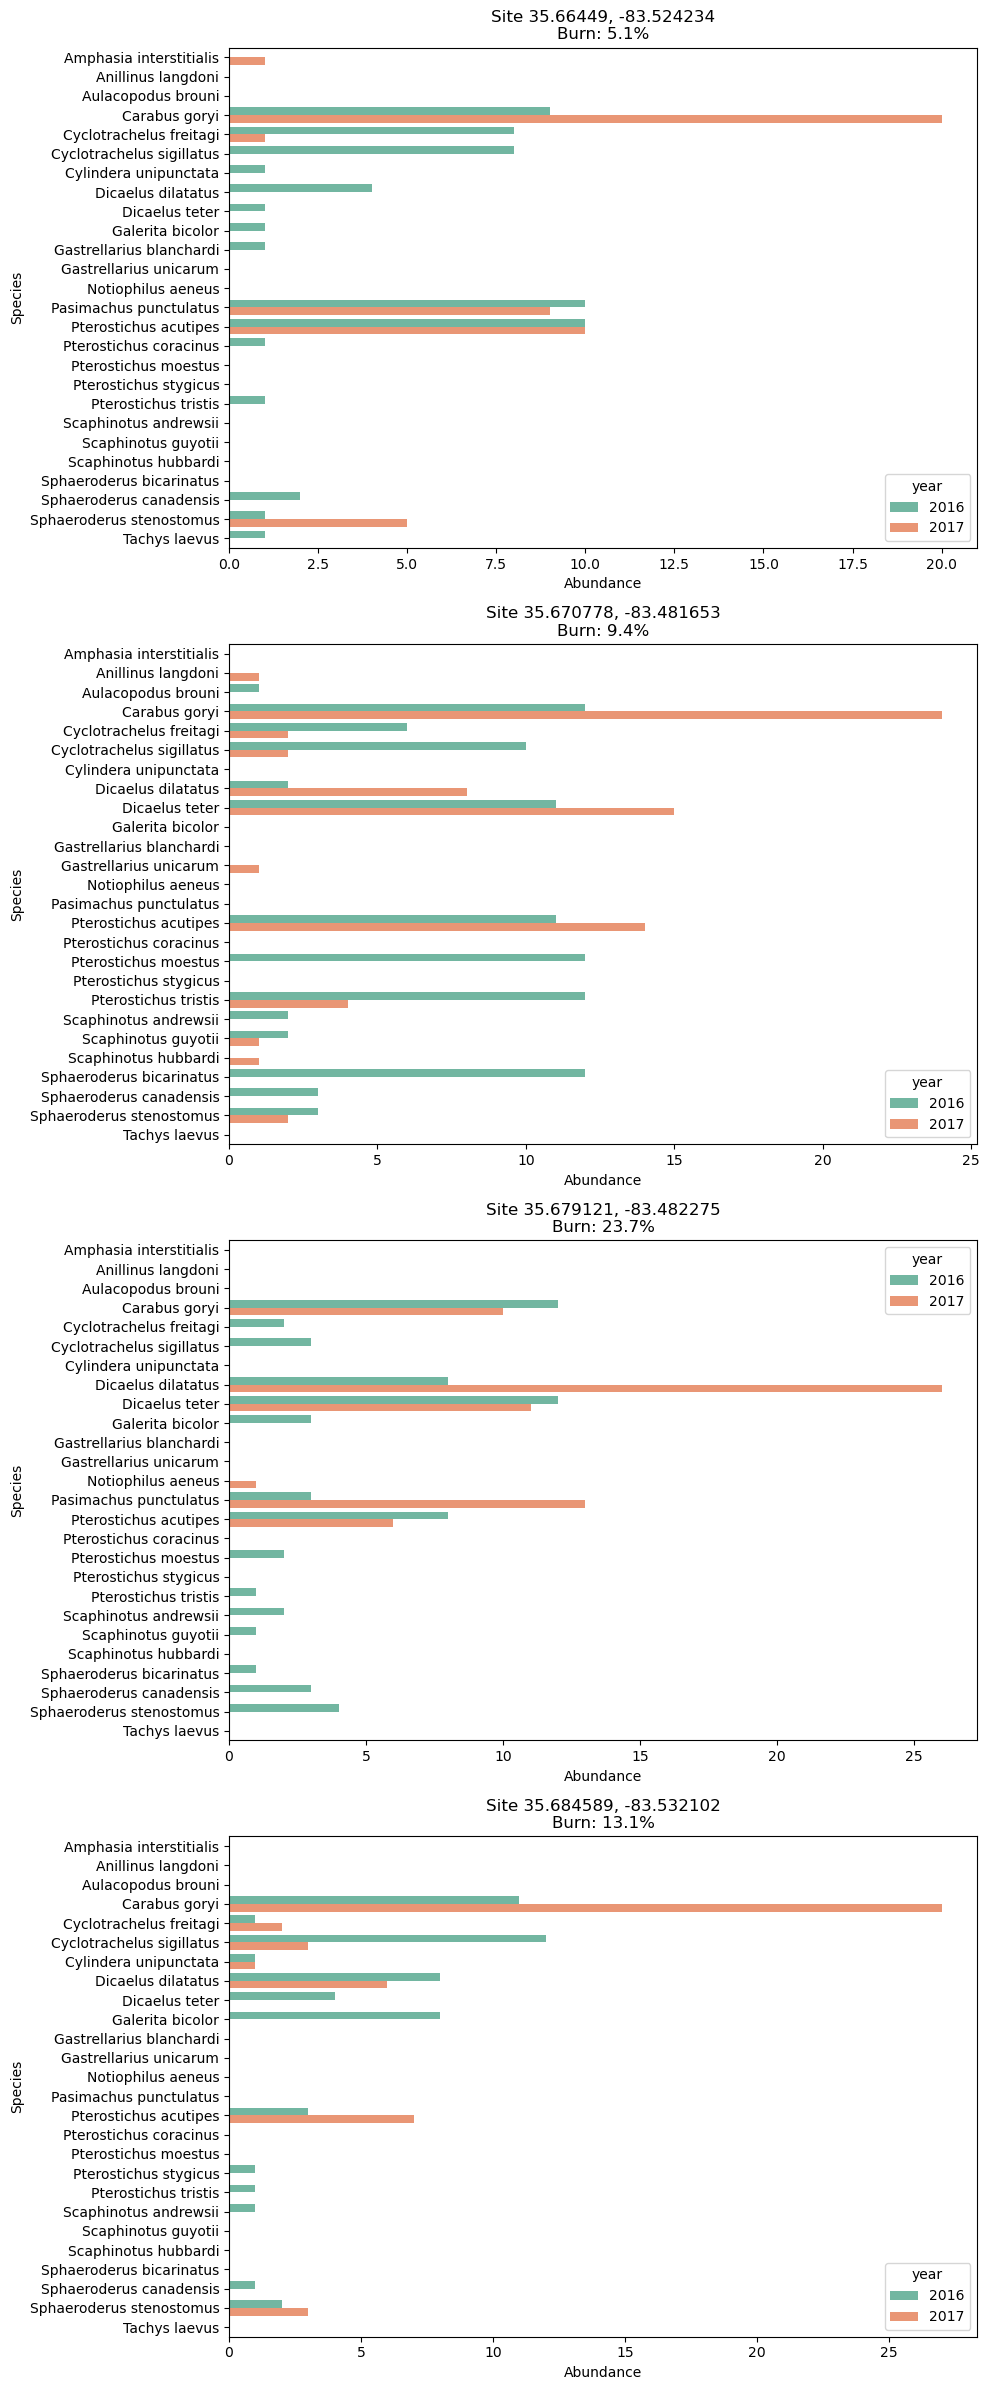

In [25]:
import geopandas as gpd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from shapely import wkt

# ---------------------------------------
# 1) Load occurrences and tag each record with its trap “site”
# ---------------------------------------
occ = gpd.read_file("/Users/kitlewers/GBIF_Remote_Sensing_Webinar_Notebooks/NEON_GRSM_Burn_Scars/code/gbif_selected_datasets_2016_2017.geojson")
occ['site'] = (
    occ['decimalLatitude'].round(6).astype(str) + ", " +
    occ['decimalLongitude'].round(6).astype(str)
)

# Keep only rows with valid species and year
occ = occ[occ['species'].notna() & occ['year'].notna()]

# Master species list (from all sites)
all_species = sorted(occ['species'].unique())

# ---------------------------------------
# 2) Load burn‐percentage data & build a site → burn_pct lookup
# ---------------------------------------
df_burn = pd.read_csv("Trap_Burn_Percentage_Export.csv")
df_burn['geometry'] = df_burn['geometry'].apply(wkt.loads)
gdf_burn = gpd.GeoDataFrame(df_burn, geometry='geometry', crs="EPSG:4326")

# Compute centroids so we can recreate the same "site" key
gdf_burn['centroid'] = gdf_burn.geometry.centroid
gdf_burn['lat'] = gdf_burn.centroid.y.round(6)
gdf_burn['lon'] = gdf_burn.centroid.x.round(6)
gdf_burn['site'] = gdf_burn['lat'].astype(str) + ", " + gdf_burn['lon'].astype(str)

# Build a dict: site → burn percentage
burn_mapping = gdf_burn.set_index('site')['burn_pct'].to_dict()

# ---------------------------------------
# 3) Prepare subplots (2×2 for visualizations for four sites)
# ---------------------------------------
sites = occ['site'].unique()
n_sites = len(sites)
n_cols = 1
n_rows = int(np.ceil(n_sites / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 10, n_rows * 6))

# ---------------------------------------
# 4) Loop over each site, build abundance data, and plot histograms
# ---------------------------------------
for ax, site in zip(axes.flat, sites):
    occ_site = occ[occ['site'] == site]
    
    # Count number of records per species-year (i.e., abundance)
    abundance = (
        occ_site
        .groupby(['species', 'year'])
        .size()
        .reset_index(name='abundance')
    )
    
    # Create full grid of all species and both years
    full_grid = pd.MultiIndex.from_product(
        [all_species, [2016, 2017]],
        names=['species', 'year']
    ).to_frame(index=False)

    # Merge with real abundance data, fill missing with 0
    abundance_full = (
        full_grid
        .merge(abundance, on=['species', 'year'], how='left')
        .fillna(0)
    )
    abundance_full['abundance'] = abundance_full['abundance'].astype(int)

    # Sort species by total abundance (across both years) for consistent order
    abundance_full['species'] = pd.Categorical(
        abundance_full['species'],
        categories=all_species,
        ordered=True
    )

    sns.barplot(
        data=abundance_full,
        x='abundance',
        y='species',
        hue='year',
        order=all_species,
        palette='Set2',
        ax=ax
    )
    
    ax.set_title(f"Site {site}\nBurn: {burn_mapping.get(site, 0.0):.1f}%", fontsize=12)
    ax.set_xlabel("Abundance")
    ax.set_ylabel("Species")

# Turn off any extra axes
for ax in axes.flat[n_sites:]:
    ax.axis('off')

plt.tight_layout()
plt.show()
